In [2]:
import numpy as np

# Single Robot Case

## Robot Dynamics

We implement a robot with the following dynamics

$\dot x = r/2(u_l+u_r)\cos\theta$ <br>
$\dot y = r/2(ul+u_r)\sin\theta$ <br>
$\dot\theta = r/L(u_r - u_l)$

In [1]:
class Robot:
    def __init__(self, state=[0,0,0], r=0.02, L=0.1):
        self.state = state
        self.r = r
        self.L = L

    # dynamics for a given state and action
    def f(self, state, action):
        return np.array([
            self.r/2*(action[0] + action[1]) * np.cos(state[2]),
            self.r/2*(action[0] + action[1]) * np.sin(state[2]),
            self.r/self.L*(action[1] - action[0])
        ])

## State Propagation

function to propagate the state, given the current state and an action:Propagate dynamics via Euler integration

$x = x_0 + \int \dot x dt \approx x_0 + \sum \dot x \cdot \Delta t$

In [3]:
class Robot(Robot):
    def propagate(self, action, dt=0.1):
        self.state = self.state + self.f(self.state, action) *dt

In [4]:
r = Robot([0,0,0])

print("Forward motion")
for i in range(3):
    r.propagate([5,5])
    print(r.state)
print("In-place motion")
for i in range(3):
    r.propagate([5,-5])
    print(r.state)

Forward motion
[0.01 0.   0.  ]
[0.02 0.   0.  ]
[0.03 0.   0.  ]
In-place motion
[ 0.03  0.   -0.2 ]
[ 0.03  0.   -0.4 ]
[ 0.03  0.   -0.6 ]


## Visualization

In [5]:
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf
import time

class Visualizer:
    def __init__(self):
        self.vis = meshcat.Visualizer()
        self.robots = dict()
        # self.vis.open()

    def jupyter(self):
        return self.vis.jupyter_cell()

    def add_robot(self, name, r):
        self.vis[name].set_object(g.Box([0.4, 0.2, 0.2]))
        self.robots[name] = r

    def update_robots(self):
        for name, r in self.robots.items():
            x, y, theta = r.state
            self.vis[name].set_transform(
                    tf.translation_matrix([x, y, 0.1]).dot(
                        tf.euler_matrix(0, 0, theta)))

In [6]:
v = Visualizer()
v.jupyter()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [8]:
r = Robot([0,0,0])
v.add_robot("r", r)
for i in range(100):
    r.propagate([5,5])
    v.update_robots()
    time.sleep(0.1)

## Controller

In [8]:
class Robot(Robot):
    # input: v, omega; output: u_l, u_r
    def action_v_omega_to_ul_ur(self, action):
        v, omega = action
        u_l = (2*v - self.L*omega)/(2*self.r)
        u_r = (2*v + self.L*omega)/(2*self.r)
        return np.array([u_l, u_r])

    def controller(self, state, state_desired, v_d, omega_d, K_x=1, K_y=1, K_theta=1):
        # compute errors
        x, y, theta = state
        x_d, y_d, theta_d = state_desired
        x_e = (x_d-x)*np.cos(theta)+(y_d-y)*np.sin(theta)
        y_e = -(x_d-x)*np.sin(theta)+(y_d-y)*np.cos(theta)
        theta_e = theta_d - theta
        # compute control output (v,w space)
        v_ctrl = v_d * np.cos(theta_e) + K_x * x_e
        omega_ctrl = omega_d + v_d * (K_y * y_e + K_theta*np.sin(theta_e))
        # convert control output to (u_l, u_r space)
        return self.action_v_omega_to_ul_ur([v_ctrl, omega_ctrl])

Add an example reference trajectory (we will see later how to generate these)

In [9]:
def reference_circle_simple(t, r=5.0):
    x = r*np.cos(t)
    y = r*np.sin(t)
    # unclear how to set theta, v, omega
    theta = 0
    v = 1
    omega = 0
    return [x,y,theta], v, omega

Simulation

In [10]:
v = Visualizer()
v.jupyter()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


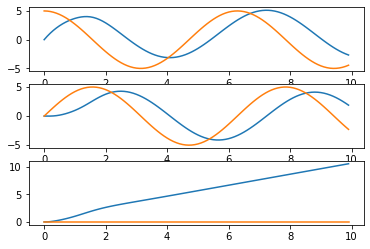

In [11]:
ts = np.arange(0,10,0.1)
states = np.empty((len(ts)+1, 3))
states_d = np.empty((len(ts)+1, 3))
r = Robot([0,0,0])
v.add_robot("r", r)
states[0] = r.state
for k, t in enumerate(ts):
    states_d[k], v_d, omega_d = reference_circle_simple(t)
    action = r.controller(states[k], states_d[k], v_d, omega_d)
    r.propagate(action)
    states[k+1] = r.state
    v.update_robots()
    time.sleep(0.1)

# plot result
import matplotlib.pyplot as plt

fig, axs = fig, ax = plt.subplots(3,1)
for k in range(3):
    axs[k].plot(ts, states[:-1,k])
    axs[k].plot(ts, states_d[:-1,k])

## Differential Flatness

$\theta = \arctan \frac{\dot y}{\dot x}$<br>
$\omega = \frac{\dot x \ddot y - \dot y \ddot x}{\dot x^2 + \dot y^2}$<br>
$v = \pm\sqrt{\dot y^2 + \dot x^2}$

In [12]:
class Robot(Robot):
    # input: x, y and derivatives; output: [x,y,theta], v, omega
    def diff_flatness(self, x, y, x_dot, y_dot, x_ddot, y_ddot):
        theta = np.arctan2(y_dot, x_dot)
        v = np.sqrt(y_dot**2 + x_dot**2)
        omega = (x_dot*y_ddot - y_dot*x_ddot) / (x_dot**2 + y_dot**2)
        return [x, y, theta], v, omega

In [13]:
def reference_circle(robot, t, r=5.0):
    x = r*np.cos(t)
    y = r*np.sin(t)
    x_dot = -r*np.sin(t)
    x_ddot = -r*np.cos(t)
    y_dot = r*np.cos(t)
    y_ddot = -r*np.sin(t)
    return robot.diff_flatness(x, y, x_dot, y_dot, x_ddot, y_ddot)

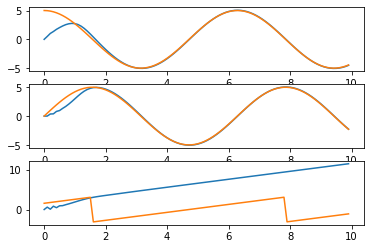

In [14]:
ts = np.arange(0,10,0.1)
states = np.empty((len(ts)+1, 3))
states_d = np.empty((len(ts)+1, 3))
r = Robot([0,0,0])
v.add_robot("r", r)
states[0] = r.state
for k, t in enumerate(ts):
    states_d[k], v_d, omega_d = reference_circle(r, t)
    action = r.controller(states[k], states_d[k], v_d, omega_d)
    r.propagate(action)
    states[k+1] = r.state
    v.update_robots()
    time.sleep(0.1)

# plot result
import matplotlib.pyplot as plt

fig, axs = fig, ax = plt.subplots(3,1)
for k in range(3):
    axs[k].plot(ts, states[:-1,k])
    axs[k].plot(ts, states_d[:-1,k])

## Motion Planning (Trajectory Optimization)

In [15]:
import cvxpy as cp

In [16]:
# Define Bezier curve functions
def bezier(p, t):
    return (1-t)**3*p[0] + 3*t*(1-t)**2*p[1]+3*t**2*(1-t)*p[2]+t**3*p[3]

def bezier_d(p, t):
    return 3*(1-t)**2 *(p[1] - p[0]) + 6*(1-t)*t*(p[2] - p[1]) + 3*t**2*(p[3] - p[2])

def bezier_dd(p, t):
    return 6*(1-t)*(p[2]-2*p[1]+p[0])+6*t*(p[3]-2*p[2]+p[1])

In [17]:
# Define and solve an optimization problem

q_start = [0,0,-np.pi/2]
q_goal = [2,1,0]
v = 1

p = cp.Variable((4,2))

cost = cp.norm2(3*(p[0]-p[1]-p[2]+p[3]))
prob = cp.Problem(
    cp.Minimize(cost),
    [
        bezier(p, 0) == q_start[0:2],
        bezier_d(p, 0) == [v*np.cos(q_start[2]), v*np.sin(q_start[2])],
        bezier(p, 1) == q_goal[0:2]
    ]
)
prob.solve()
print(p.value)

[[ 1.97082294e-33 -4.98469828e-23]
 [ 2.04106859e-17 -3.33333333e-01]
 [ 2.00000000e+00  1.33333333e+00]
 [ 2.00000000e+00  1.00000000e+00]]


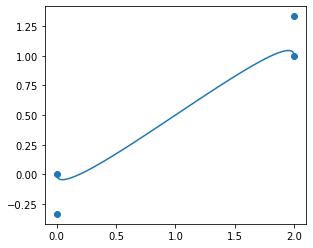

In [18]:
# Plot the result
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.scatter(p.value[:,0], p.value[:,1])
ts = np.linspace(0, 1, 100)
ps = np.empty((len(ts), 2))
for k, t in enumerate(ts):
    ps[k] = bezier(p.value, t)
ax.plot(ps[:,0], ps[:,1])

In [19]:
def reference_bezier(robot, p, t):
    t = np.clip(t, 0, 1)
    x, y = bezier(p, t)
    x_dot, y_dot = bezier_d(p, t)
    x_ddot, y_ddot = bezier_dd(p, t)
    return robot.diff_flatness(x, y, x_dot, y_dot, x_ddot, y_ddot)

In [20]:
class Visualizer(Visualizer):
    # where vertices are [[x1,y1],[x2,y2],...]
    def add_line2d(self, name, line, color=0xff0000):
        # convert to 3xN of float32
        vertices = np.zeros((3, line.shape[1]), dtype=np.float32)
        print(line.shape)
        vertices[0:2,:] = line
        self.vis[name].set_object(g.Line(g.PointsGeometry(vertices), g.MeshBasicMaterial(color=color)))

    def add_bezier(self, name, p, color=0xff0000):
        ts = np.linspace(0, 1, 100)
        ps = np.empty((len(ts), 2))
        for k, t in enumerate(ts):
            ps[k] = bezier(p, t)
        self.add_line2d(name, ps.T, color)

In [21]:
v = Visualizer()
v.jupyter()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [22]:
v.add_bezier("bezier", p.value)

ts = np.arange(0,1,0.1)
states = np.empty((len(ts)+1, 3))
states_d = np.empty((len(ts)+1, 3))
r = Robot(q_start)
v.add_robot("r", r)
states[0] = r.state
for k, t in enumerate(ts):
    states_d[k], v_d, omega_d = reference_bezier(r, p.value, t)
    print(states_d[k], v_d, omega_d)
    action = r.controller(states[k], states_d[k], v_d, omega_d)
    r.propagate(action)
    states[k+1] = r.state
    v.update_robots()
    time.sleep(0.1)

(2, 100)
[ 1.97082294e-33 -4.98469828e-23 -1.57079633e+00] 1.0 11.999999999999996
[ 0.056      -0.044       0.07393904] 1.0829589096544705 8.18553888130969
[0.208      0.008      0.44684247] 2.129037341147402 1.5884221673138015
[0.432     0.132     0.5427505] 2.942923716306625 0.5542213190467392
[0.704      0.304      0.57832549] 3.4393022548185552 0.20289463005545763
[1.        0.5       0.5880026] 3.6055512754639887 2.049642507000289e-16
[1.296      0.696      0.57832549] 3.4393022548185552 -0.20289463005545813
[1.568     0.868     0.5427505] 2.942923716306625 -0.5542213190467394
[1.792      0.992      0.44684247] 2.129037341147402 -1.5884221673138024
[1.944      1.044      0.07393904] 1.0829589096544707 -8.185538881309684


# Multi-Robot

## Compute and Visualize Voronoi Regions

In [23]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from voronoi_helper import *

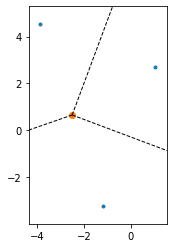

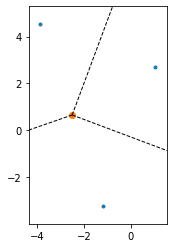

In [24]:
N = 3
points = np.random.uniform([-5,-5], [5,5], (N,2))
vor = Voronoi(points)
fig, ax = plt.subplots()
ax.set_aspect(1)
voronoi_plot_2d(vor, ax)

In [25]:
class Visualizer(Visualizer):

    # where line_segments are [[[xs, ys], [xg,yg]], ...]
    def add_line_segments2d(self, name, line_segments, color=0xff0000):
        # convert to 3xN of float32
        vertices = np.zeros((3, len(line_segments)*2), dtype=np.float32)
        for k, ls in enumerate(line_segments):
            vertices[0:2, k*2] = ls[0]
            vertices[0:2, k*2+1] = ls[1]
        self.vis[name].set_object(g.LineSegments(g.PointsGeometry(vertices), g.MeshBasicMaterial(color=color)))

In [26]:
v = Visualizer()
v.jupyter()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [27]:
robots = [Robot(np.hstack((point, [0]))) for point in points]
line_segments = extract_line_segments(vor)
for k, r in enumerate(robots):
        v.add_robot("r{}".format(k), r)
v.update_robots()
v.add_line_segments2d("voronoi", line_segments)

In [28]:
N = 10
start_states = np.random.uniform([-5,-5,0], [5,5,2*np.pi], (N,3))
goal_states = np.random.uniform([-5,-5,0], [5,5,2*np.pi], (N,3))

In [29]:
def plan(states, goals, i):
    vor = Voronoi(states[:,0:2])
    hyperspaces = extract_hyperspaces_per_point(vor)

    v = 0.1
    radius = 0.2

    p = cp.Variable((4,2))

    cost = cp.norm2(3*(p[0]-p[1]-p[2]+p[3])) + 0.1*cp.norm2(bezier(p, 1) - goals[i, 0:2])
    constraints = [
        bezier(p, 0) == states[i,0:2],
        bezier_d(p, 0) == [v*np.cos(states[i,2]), v*np.sin(states[i,2])],
        # bezier(p, 1) == q_goal[0:2]
    ]
    for n, d in hyperspaces[i]:
        constraints.extend([
            p[0] @ n >= d+radius,
            p[1] @ n >= d+radius,
            p[2] @ n >= d+radius,
            p[3] @ n >= d+radius,
        ])

    prob = cp.Problem(
        cp.Minimize(cost),
        constraints
    )
    prob.solve()
    return p.value, vor


In [30]:
v = Visualizer()
v.jupyter()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [32]:
ts = np.arange(0,10,0.1)
states = np.empty((len(ts)+1, N, 3))
states_d = np.empty((len(ts)+1, N, 3))
actions = np.zeros((len(ts), N, 2))
states[0] = start_states
robots = [Robot(s) for s in start_states]
for k, r in enumerate(robots):
    v.add_robot("r{}".format(k), r)
v.update_robots()

for k, t in enumerate(ts):
    for i in range(N):
        p, vor = plan(states[k], goal_states, i)
        v.add_bezier("plan{}".format(i), p, 0x0000ff00)

        line_segments = extract_line_segments(vor)
        v.add_line_segments2d("voronoi{}".format(i), line_segments)
        # #
        # if p is not None and i == 0:
        #     fig, ax = plt.subplots()
        #     ax.set_aspect(1)
        #     voronoi_plot_2d(vor, ax)
        #     ax.set_xlim(-2, 2)
        #     ax.set_ylim(-2,2)
        #     tsd = np.linspace(0, 1, 100)
        #     ps = np.empty((len(tsd), 2))
        #     for kd, td in enumerate(tsd):
        #         ps[kd] = bezier(p, td)
        #     ax.plot(ps[:,0], ps[:,1])
        #
        if p is not None:
            states_d[k, i], v_d, omega_d = reference_bezier(robots[i], p, 0.1)
            actions[k, i] = robots[i].controller(states[k, i], states_d[k, i], v_d, omega_d)
        else:
            print("Warning: infeasible optimization")
        robots[i].propagate(actions[k,i])
        states[k+1, i] = robots[i].state
    v.update_robots()


(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(2, 100)
(